<font color=red><h1> 1. Loading data and packages</h1></font>

<font color=green><h2> 1.1 Loadingpackages</h2></font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import tensorflow
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
import yfinance as yf
from datetime import timedelta, datetime
from tabulate import tabulate
import mplfinance as mpf
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

<font color=green><h2> 1.2 Loading data</h2></font>

In [2]:
Start_date=datetime.strptime('2023-01-23', '%Y-%m-%d').date()
End_date=datetime.strptime('2023-04-24', '%Y-%m-%d').date()

In [3]:
Ticker='MSFT'
Stock_data=yf.download(Ticker,Start_date,End_date)
Adj_close=Stock_data.loc[:,'Adj Close']

[*********************100%%**********************]  1 of 1 completed


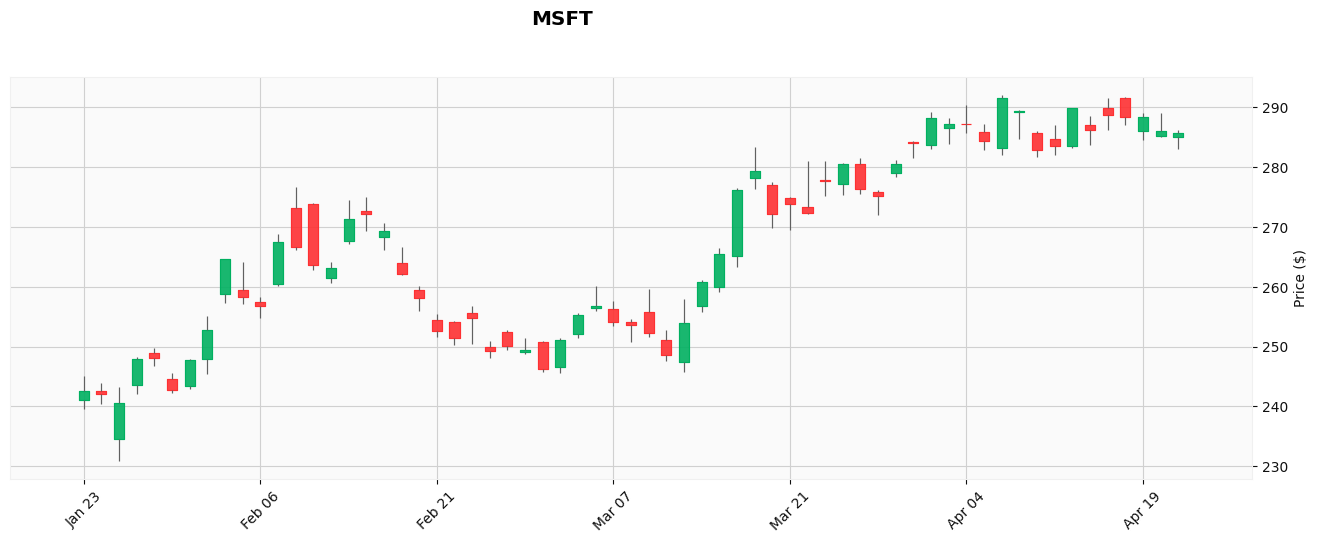

In [4]:
Trace= go.Scatter(x=Adj_close.index,y=Adj_close.values,name=Ticker,line=dict(color='blue', width=2),marker=dict(size=2))

layout = go.Layout(xaxis = dict(title = 'Date'),yaxis = dict(title = 'Adj Close'),template = 'plotly_white' )

fig = go.Figure(data=Trace, layout=layout)

fig.show()
mpf.plot(Stock_data, type='candle', style='yahoo', title=Ticker,ylabel='Price ($)',figratio=(15, 5))

<font color=red><h1> 2. Data Peparation</h1></font>

<font color=green><h2> 2.1 Train/test Data</h2></font>

In [ ]:
nb_sequence=5
nb_test=20

data_train=Adj_close[:len(Adj_close)-nb_test]
data_test=Adj_close[len(Adj_close)-nb_test:]

#Scale the train data in order to improve the performance of our model
scaler=MinMaxScaler(feature_range=(0,1))
Train_Scaled=scaler.fit_transform(pd.DataFrame(Adj_close))
Test_Scaled=scaler.transform(pd.DataFrame(Adj_close))

X_Train=[]
Y_Train=[]

X_Test=[]
Y_Test=[]
Y_Test_index=[]
for i in range(len(Adj_close)):
    if i<len(Adj_close)-nb_sequence-nb_test:
        X_Train.append(Train_Scaled[i:i+nb_sequence])
        Y_Train.append(Train_Scaled[i+nb_sequence])
    if i>=len(Adj_close)-nb_test and i<len(Adj_close)-nb_sequence:
        X_Test.append(Test_Scaled[i:i+nb_sequence])
        Y_Test.append(Test_Scaled[i+nb_sequence])
        Y_Test_index.append(i+nb_sequence)
X_Train,Y_Train=np.array(X_Train),np.array(Y_Train)

<font color=green><h2> 2.2 Optimal Architecture</h2></font>

In [ ]:
"The code below provides the optimal parameters for the LSTM architecture. However, a powerful computer is required to run it and obtain the results ^-^"

def LSTM_arch(numb_layers1,numb_units_layers1,layer1_dropout,numb_layers2,numb_units_layers2,layer2_dropout,numb_units_last_layer,dropout_last,numb_dense_layers,numb_units_dense_layers,dropout_dense):
    model=Sequential()
   
    for i in range(numb_layers1):
        model.add(LSTM(units=numb_units_layers1,return_sequences=True,input_shape=(X_Train.shape[1],1)))
        model.add(Dropout(layer1_dropout))
    for j in range(numb_layers2-1):
        model.add(LSTM(units=numb_units_layers2,return_sequences=True,input_shape=(X_Train.shape[1],1)))
        model.add(Dropout(layer2_dropout))
    model.add(LSTM(units=numb_units_last_layer, return_sequences=False))
    model.add(Dropout(dropout_last))

    for i in range(numb_dense_layers-1):
        model.add(Dense(units=numb_units_dense_layers))
        model.add(Dropout(dropout_dense))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return(model)

LSTM_model = KerasRegressor(build_fn=LSTM_arch, epochs=10,numb_layers1=1,numb_units_layers1=200,layer1_dropout=0.2,numb_layers2=1,numb_units_layers2=80,layer2_dropout=0.2,numb_units_last_layer=80,dropout_last=0.2,numb_dense_layers=1,numb_units_dense_layers=60,dropout_dense=0.2)


Lstm_parameters={'numb_layers1':[1,2,3,4,5],
                 'numb_units_layers1':[50,100,150,200,250],
                 'numb_layers2':[1,2,3,4,5],
                 'layer1_dropout':[0.1,0.2,0.3],
                 'numb_units_layers2':[50,100,150,200,250],
                 'layer2_dropout':[0.1,0.2,0.3],
                 'numb_units_last_layer':[50,100,150,200,250],
                 'dropout_last':[0.1,0.2,0.3],
                 'numb_dense_layers':[1,2,3,4],
                 'numb_units_dense_layers':[50,60,70,80,90],
                 'dropout_dense':[0.1,0.2,0.3]}

Grid = GridSearchCV(estimator=LSTM_model, param_grid=Lstm_parameters)

Grid.fit(X_Train,Y_Train,epochs=10)

<font color=green><h1> 2.3 Example</h1></font>

In [ ]:
#Fix the initial weights
np.random.seed(42)
tensorflow.random.set_seed(42)
random.seed(42)
tensorflow.config.experimental.enable_op_determinism()

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1702
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0713
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0319
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0478
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0278
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0301
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0402
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0303
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0304
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0255
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0247
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0240
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0260
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0255
Epoch 15/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0260
Epoch 16/200
2/2 ━━

Text(0.5, 1.0, 'Loss function')

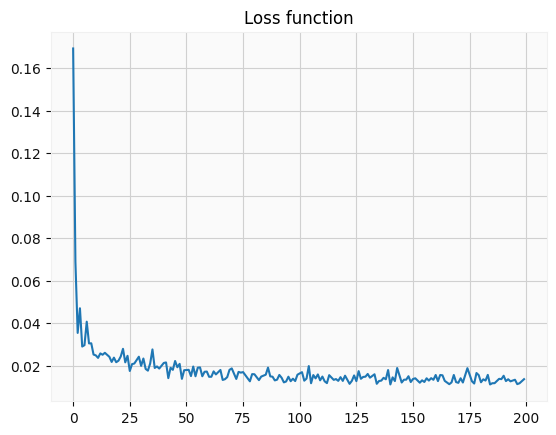

In [81]:
model = Sequential()
model.add(LSTM(units=400, return_sequences=True, input_shape=(5, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=150))
model.add(Dropout(0.2))
model.add(Dense(units=100,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
MODEL=model.fit(X_Train, Y_Train, epochs=200)

predictions = model.predict(np.array(X_Test))
predictions = scaler.inverse_transform(predictions)

Val=Adj_close[Y_Test_index]
plt.plot(MODEL.history['loss'])
plt.title("Loss function")



<font color=red><h1> 3. Prediction</h1></font>

In [80]:
Trace1= go.Scatter(x=Adj_close.index,y=Adj_close.values,name=Ticker,line=dict(color='blue', width=2),marker=dict(size=2))
Trace2= go.Scatter(x=Val.index,y=[i[0] for i in predictions],name='predictions',line=dict(color='red', width=2),marker=dict(size=2))

layout = go.Layout(xaxis = dict(title = 'Date'),yaxis = dict(title = 'Adj Close'),template = 'plotly_white' )
Trace=[Trace1,Trace2]
fig = go.Figure(data=Trace, layout=layout)

fig.show()

![Predictions](LSTMn.JPG)